In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
import math
import copy
import gc
import sys

from tqdm import tqdm
from glob import glob
from konlpy.tag import Mecab

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# import warnings
# warnings.filterwarnings(action='ignore')

In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [7]:
# reproduction을 위한 random seed 고정
# 대회나 논문 검증 시 등 학습한 모델을 reproduction 하기 위해 seed를 고정
# seed 난수값 -> 난수 생성 알고리즘을 사용해 난수 생성
# 난수 알고리즘을 실행하기 위해 쓰는 수를 seed라고 함
# 같은 시드를 사용하면 계속 같은 패턴의 난수를 생성할 수 있음 

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [8]:
seed_everything(42)

In [11]:
DIR = "../data"
TRAIN_SOURCE = os.path.join(DIR, "train.json")
TEST_SOURCE = os.path.join(DIR, "test.json")

In [12]:
with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())
    
with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [13]:
train = pd.DataFrame(columns=['uid', 'title', 'region', 'context', 'summary'])
uid = 1000
for data in TRAIN_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        train.loc[uid, 'uid'] = uid
        train.loc[uid, 'title'] = data['title']
        train.loc[uid, 'region'] = data['region']
        train.loc[uid, 'context'] = context[:-1]
        train.loc[uid, 'summary'] = data['label'][agenda]['summary']
        uid += 1

test = pd.DataFrame(columns=['uid', 'title', 'region', 'context'])
uid = 2000
for data in TEST_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        test.loc[uid, 'uid'] = uid
        test.loc[uid, 'title'] = data['title']
        test.loc[uid, 'region'] = data['region']
        test.loc[uid, 'context'] = context[:-1]
        uid += 1

In [14]:
train['total'] = train.title + ' ' + train.region + ' ' + train.context
test['total'] = test.title + ' ' + test.region + ' ' + test.context

In [15]:
train.head()

uid                                 title region  \
1000  1000         제207회 완주군의회(임시회) 제 1 차 본회의회의록     완주   
1001  1001         제207회 완주군의회(임시회) 제 1 차 본회의회의록     완주   
1002  1002         제207회 완주군의회(임시회) 제 1 차 본회의회의록     완주   
1003  1003         제207회 완주군의회(임시회) 제 1 차 본회의회의록     완주   
1004  1004  제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록     완주   

                                                context  \
1000  의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제...   
1001  의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결...   
1002  다음은 의사일정 제2항 제207회 완주군의회 임시회 회의록 서명의원 선출의 건을 상...   
1003  다음은 의사일정 제3항 본회의 휴회의 건을 상정합니다. 상임의원회 의정활동을 위하여...   
1004  의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제251회 완주군의회 제1차 정...   

                                                summary  \
1000                     제207회 완주군의회 임시회 제1차 본회의 개의 선포.   
1001   제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.   
1002    제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.   
1003  8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...   
1004                 제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.   

                                                  total  
1000  제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...  
1001  제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....  
1002  제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제2항 ...  
1003  제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제3항 ...  
1004  제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록 완주 의석을 정돈...

## set hyperparameter

In [16]:
encoder_len = 500
decoder_len = 50
max_vocab_size = 20000
batch_size = 32
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 20
learning_rate = 1e-4
device = torch.device("cuda:0")

In [17]:
device

device(type='cuda', index=0)

In [18]:
df_train = train.iloc[:-200]
df_val = train.iloc[-200:]

## tokenization

In [19]:
class Mecab_Tokenizer():
    def __init__(self, max_length, mode, max_vocab_size=-1):
        self.text_tokenizer = Mecab()
        self.mode = mode
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        self.max_length = max_length
        self.word_count = {}
        self.max_vocab_size = max_vocab_size
        
        # 띄어쓰기를 찾기 위한 태그 목록
        self.font_blank_tag = [
            '', 'EC', 'EC+JKO', 'EF', 'EP+EC', 'EP+EP+EC', 'EP+ETM', 'EP+ETN+JKO', 'ETM', 'ETN', 'ETN+JKO', 'ETN+JX', 'IC', 'JC', 'JKB', 'JKB+JX', 'JKO',
            'JKQ', 'JKS', 'JX', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ','MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+JKO', 'NNB+VCP+EC', 'NNBC', 'NNG', 'NNG+JX+JKO',
            'NNG+VCP+EC', 'NNP', 'NNP+JX', 'NP', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NR', 'SC', 'SF', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'UNKNOWN',
            'VA+EC', 'VA+EC+VX+ETM', 'VA+ETM', 'VA+ETN+JKB+JX', 'VCN+EC', 'VCN+ETM', 'VCP', 'VCP+EC', 'VCP+EP+EC', 'VCP+EP+ETM', 'VCP+ETM', 'VCP+ETN',
            'VV+EC', 'VV+EC+JX', 'VV+EC+VX+EC', 'VV+EC+VX+ETM', 'VV+EP+EC', 'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VX+EC', 'VX+EC+VX+EP+EC', 'VX+EP+ETM',
            'VX+ETM', 'XPN', 'XR', 'XSA+EC', 'XSA+EC+VX+ETM', 'XSA+ETM', 'XSN', 'XSV+EC', 'XSV+EP+EC', 'XSV+ETM', 'XSV+ETN', 'XSV+JKO'
        ]
        self.back_blank_tag = [
            '', 'IC', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ', 'MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+VCP', 'NNB+VCP+EC', 'NNB+VCP+EF', 'NNBC', 'NNBC+VCP+EC',
            'NNG', 'NNG+JC', 'NNG+JX+JKO', 'NNG+VCP', 'NNG+VCP+EC', 'NNG+VCP+ETM', 'NNP', 'NNP+JX', 'NP', 'NP+JKG', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NP+VCP+EF',
            'NR', 'SC', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'VA', 'VA+EC', 'VA+EC+VX+ETM', 'VA+EF', 'VA+ETM', 'VA+ETN', 'VA+ETN+JKB+JX', 'VCN', 'VCN+EC', 'VCN+EF', 'VCN+ETM',
            'VCN+ETN', 'VCP', 'VCP+EF', 'VV', 'VV+EC', 'VV+EC+JX', 'VV+EC+VX', 'VV+EC+VX+EC', 'VV+EC+VX+EF', 'VV+EC+VX+EP+EC', 'VV+EC+VX+ETM', 'VV+EF', 'VV+EP', 'VV+EP+EC',
            'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VV+ETN+VCP+EF', 'VX', 'VX+ETM', 'XPN', 'XR', 'XSA+ETN+VCP+EF', 'XSN'
        ]
        
    def morpheme(self, sentence_list):
        new_sentence = []
        for i, sentence in tqdm(enumerate(sentence_list)):
            temp = []
            if self.mode == 'dec':
                temp.append('sos_')
            for t in self.text_tokenizer.pos(sentence):
                temp.append('_'.join(t))
            if self.mode == 'dec':
                temp.append('eos_')
            new_sentence.append(' '.join(temp))
            
        return new_sentence
    
    def fit(self, sentence_list):
        for sentence in tqdm(sentence_list):
            for word in sentence.split(' '):
                try:
                    self.word_count[word] += 1
                except:
                    self.word_count[word] = 1
        self.word_count = dict(sorted(self.word_count.items(), key=self.sort_target, reverse=True))
        
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        if self.max_vocab_size == -1:
            for i, word in enumerate(list(self.word_count.keys())):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        else:
            for i, word in enumerate(list(self.word_count.keys())[:self.max_vocab_size]):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        
    def sort_target(self, x):
        return x[1]
            
    def txt2token(self, sentence_list):
        tokens = []
        for sentence in tqdm(sentence_list):
            token = [0]*self.max_length
            for i, w in enumerate(sentence.split(' ')):
                if i == self.max_length:
                    break
                try:
                    token[i] = self.txt2idx[w]
                except:
                    token[i] = self.txt2idx['unk_']
            tokens.append(token)
        return np.array(tokens)
    
    def convert(self, token):
        sentence = []
        for j, i in enumerate(token):
            if self.mode == 'enc':
                if i != self.txt2idx['pad_']:
                    sentence.append(self.idx2txt[i].split('_')[0])
            elif self.mode == 'dec':
                if i == self.txt2idx['eos_'] or i == self.txt2idx['pad_']:
                    break
                elif i != 0:
                    sentence.append(self.idx2txt[i].split('_')[0])
                    # 앞뒤 태그를 확인하여 띄어쓰기 추가
                    if self.idx2txt[i].split('_')[1] in self.font_blank_tag:
                        try:
                            if self.idx2txt[token[j+1]].split('_')[1] in self.back_blank_tag:
                                sentence.append(' ')
                        except:
                            pass
        sentence = "".join(sentence)
        if self.mode == 'enc':
            sentence = sentence[:-1]
        elif self.mode == 'dec':
            sentence = sentence[3:-1]
            
        return sentence

In [20]:
src_tokenizer = Mecab_Tokenizer(encoder_len, mode='enc', max_vocab_size=max_vocab_size)
tar_tokenizer = Mecab_Tokenizer(decoder_len, mode='dec', max_vocab_size=max_vocab_size)

In [21]:
train_src = src_tokenizer.morpheme(df_train.total)
val_src = src_tokenizer.morpheme(df_val.total)
test_src = src_tokenizer.morpheme(test.total)

train_tar = tar_tokenizer.morpheme(df_train.summary)
val_tar = tar_tokenizer.morpheme(df_val.summary)

2794it [00:12, 228.94it/s]
200it [00:00, 306.19it/s]
506it [00:01, 278.67it/s]
2794it [00:00, 4902.60it/s]
200it [00:00, 5493.31it/s]


train_src_max_len : 6476


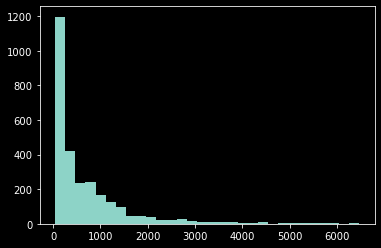

train_tar_max_len : 342


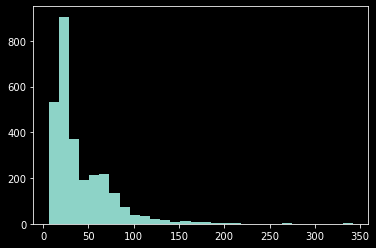

In [22]:
train_src_len = []
for m in train_src:
    m_len = len(m.split(' '))
    train_src_len.append(m_len)
print('train_src_max_len :', max(train_src_len))
plt.hist(train_src_len, bins=30)
plt.show()

train_tar_len = []
for m in train_tar:
    m_len = len(m.split(' '))
    train_tar_len.append(m_len)
print('train_tar_max_len :', max(train_tar_len))
plt.hist(train_tar_len, bins=30)
plt.show()

In [23]:
src_tokenizer.fit(train_src)
tar_tokenizer.fit(train_tar)

100%|██████████| 2794/2794 [00:00<00:00, 94242.65it/s]


In [24]:
train_src_tokens = src_tokenizer.txt2token(train_src)
val_src_tokens = src_tokenizer.txt2token(val_src)
test_src_tokens = src_tokenizer.txt2token(test_src)

train_tar_tokens = tar_tokenizer.txt2token(train_tar)
val_tar_tokens = tar_tokenizer.txt2token(val_tar)

100%|██████████| 200/200 [00:00<00:00, 81371.69it/s]


In [ ]:
input_vocab_size = len(src_tokenizer.txt2idx)
target_vocab_size = len(tar_tokenizer.txt2idx)

In [ ]:
input_vocab_size, target_vocab_size

In [ ]:
df_train.summary.iloc[0]

In [ ]:
train_tar_tokens[0], tar_tokenizer.convert(train_tar_tokens[0])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, src_tokens, tar_tokens, mode='train'):
        self.mode = mode
        self.src_tokens = src_tokens
        if self.mode == 'train':
            self.tar_tokens = tar_tokens
            
    def __len__(self):
        return len(self.src_tokens)
    
    def __getitem__(self, i):
        src_token = self.src_tokens[i]
        if self.mode == 'train':
            tar_token = self.tar_tokens[i]
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long),
                'tar_token' : torch.tensor(tar_token, dtype=torch.long),
            }
        else:
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long)
            }

In [ ]:
train_dataset = CustomDataset(train_src_tokens, train_tar_tokens)
val_dataset = CustomDataset(val_src_tokens, val_tar_tokens)
test_dataset = CustomDataset(test_src_tokens, None, 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)